### Libraries and Dependencies

In [126]:
# !pip install pandas
# !pip install kagglehub
# !pip install xgboost
# !pip install lightgbm
# !pip install transformers
# !pip install --upgrade pandas
# !pip install torch
# !pip install catboost
# !pip install better-profanity
# !pip install textblob
# !pip install wordcloud
# !pip install tqdm

In [222]:
import dask
print("Pandas version:", pd.__version__)
print("Dask version:", dask.__version__)

Pandas version: 2.2.3
Dask version: 2021.10.0


In [272]:
# Libraries required for the Analysis
import pandas as pd
import kagglehub
import os
import re
from tqdm import tqdm
from datetime import datetime
from better_profanity import profanity
from textblob import TextBlob 
import plotly.express as px
import plotly.graph_objs as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report

# Downloading stopwords
nltk.download('stopwords')

# Suppress all warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [224]:
# Load the dataset using the provided path
file_path = r"C:\Users\Hamza\Desktop\Coding\Talha\Policy Model\tweets.csv"
df = pd.read_csv(file_path)
df = df.drop(columns=["Likes", "Retweets"])
df.dropna(inplace=True)
df.head()

,Unnamed: 0,Date,User,Tweet
0,0,2023-03-29 15:42:36+00:00,AnandPatni8,@vinodkapri @RahulGandhi Respected Indian Citi...
1,1,2023-03-29 15:42:05+00:00,dhinamum,"*Respected Indian Citizens,* Namaskaar I Am Th..."
2,2,2023-03-29 15:34:29+00:00,PrincetonCGI,1/n-Meet Filmmaker Prakash Jha in New Jersey t...
3,3,2023-03-29 15:31:43+00:00,RishiJoeSanu,@MrinalWahal Why would politicians stop using ...
4,4,2023-03-29 15:26:48+00:00,itweetsensee,@annamalai_k @narendramodi A state level presi...


In [225]:
# Checking the number of unique values of each column
df.nunique()

Unnamed: 0    50000
Date          49821
User          35109
Tweet         49569
dtype: int64

### Data Cleaning

In [226]:
# Define stop words list globally
STOP_WORDS = set(stopwords.words('english'))

def clean_tweet(tweet):
    def to_lower_case(text):
        return text.lower()

    def censor_profanity(text):
        profanity.load_censor_words()
        return profanity.censor(text)

    def remove_twitter_handles(text):
        return re.sub(r'@[^\s]+', '', text)

    def remove_hashtags(text):
        return re.sub(r'\B#\S+', '', text)

    def remove_urls(text):
        return re.sub(r"http\S+", "", text)

    def remove_special_chars_and_punctuations(text):
        return re.sub(r'\W', ' ', text)

    def remove_unwanted_single_chars(text):
        text = re.sub(r'\s+[a-hj-z]\s+', ' ', text)  # Removing single characters except 'a' and 'i'
        text = re.sub(r'\s+i\s+', ' I ', text)
        text = re.sub(r'\s+a\s+', ' a ', text)
        return text

    def replace_multiple_spaces(text):
        return re.sub(r'\s+', ' ', text, flags=re.I)

    def remove_stop_words(text):
        return ' '.join([word for word in text.split() if word not in STOP_WORDS])

    # Apply cleaning steps
    tweet = to_lower_case(tweet)
    tweet = censor_profanity(tweet)
    tweet = remove_twitter_handles(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_urls(tweet)
    tweet = remove_special_chars_and_punctuations(tweet)
    tweet = remove_unwanted_single_chars(tweet)
    tweet = replace_multiple_spaces(tweet)
    tweet = remove_stop_words(tweet)

    return tweet

# Display the Progress bar
tqdm.pandas()


# Select a random sample
# df_sample = df.sample(n=10000, random_state=42)
# df_sample = df_sample.reset_index(drop=True)
# df_sample.head()


df['Cleaned_Tweet'] = df['Tweet'].progress_apply(clean_tweet)
print(df[['Tweet', 'Cleaned_Tweet']].head())

100%|██████████| 50000/50000 [1:31:37<00:00,  9.09it/s]  

                                               Tweet  \
0  @vinodkapri @RahulGandhi Respected Indian Citi...   
1  *Respected Indian Citizens,* Namaskaar I Am Th...   
2  1/n-Meet Filmmaker Prakash Jha in New Jersey t...   
3  @MrinalWahal Why would politicians stop using ...   
4  @annamalai_k @narendramodi A state level presi...   

                                       Cleaned_Tweet  
0  respected indian citizens namaskaar I original...  
1  respected indian citizens namaskaar I original...  
2  1 meet filmmaker prakash jha new jersey talkin...  
3  would politicians stop using religion politics...  
4  state level president knows policy pm union mi...  


### Sentiment Analysis

In [228]:
# Define a function to calculate sentiment polarity
def get_sentiment_polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Apply the function to the 'Tweet' column and create a new 'Polarity' column
df['Polarity'] = df['Tweet'].progress_apply(get_sentiment_polarity)

# Create the new column using a lambda function to classify the tweets as Positive, Negative, or Neutral
df['Sentiment'] = df['Polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')
print(df[['Tweet', 'Polarity', 'Sentiment']].head())

100%|██████████| 50000/50000 [00:12<00:00, 4163.32it/s]

                                               Tweet  Polarity Sentiment
0  @vinodkapri @RahulGandhi Respected Indian Citi... -0.062500  Negative
1  *Respected Indian Citizens,* Namaskaar I Am Th... -0.062500  Negative
2  1/n-Meet Filmmaker Prakash Jha in New Jersey t...  0.173232  Positive
3  @MrinalWahal Why would politicians stop using ...  0.000000   Neutral
4  @annamalai_k @narendramodi A state level presi...  0.214286  Positive


In [229]:
# Count the number of occurrences for each sentiment
sentiment_counts = df['Sentiment'].value_counts()
# display the number of Twitter users who have expressed a positive sentiment,a negative sentiment and a neutral sentiment about the given topic.
positive_percent = sentiment_counts['Positive'] / len(df) * 100
negative_percent = sentiment_counts['Negative'] / len(df) * 100
neutral_percent = sentiment_counts['Neutral'] / len(df) * 100
print("%.2f percent of twitter users feel positive." %positive_percent)

print("%.2f percent of twitter users feel negative."%negative_percent)

print("%.2f percent of twitter users feel neutral."%neutral_percent)

47.93 percent of twitter users feel positive.
25.94 percent of twitter users feel negative.
26.13 percent of twitter users feel neutral.


### Data Visualization

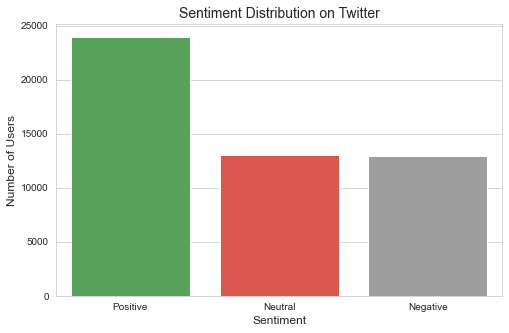

In [230]:
# 1. Sentiment Distribution
# Count the number of occurrences for each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Define a professional color palette
colors = ['#4CAF50', '#F44336', '#9E9E9E']  # Green for Positive, Red for Negative, Grey for Neutral

# Create a bar plot for sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)
plt.title("Sentiment Distribution on Twitter", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

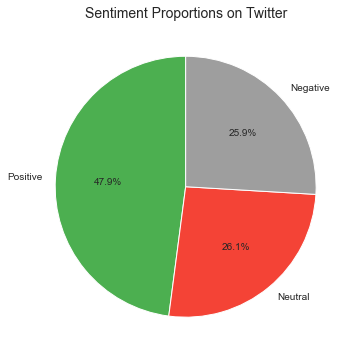

In [231]:
# Define a professional color palette
colors = ['#4CAF50', '#F44336', '#9E9E9E']

# Create a pie chart for sentiment distribution
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Sentiment Proportions on Twitter", fontsize=14)
plt.show()

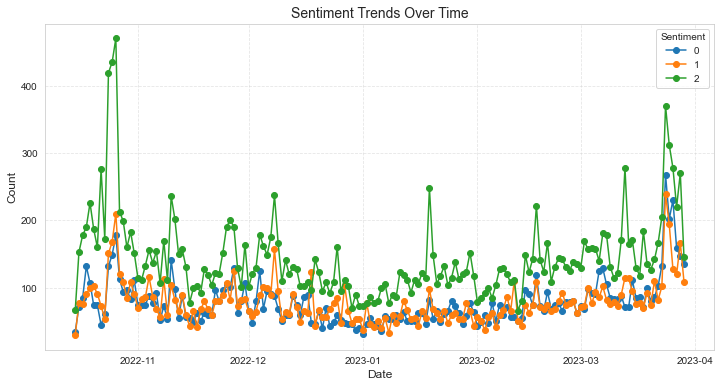

In [270]:
# Time Series Plot for Sentiment Trends
df['Date'] = pd.to_datetime(df['Date'])

# Group by date and calculate the count of each sentiment
sentiment_trend = df.groupby([df['Date'].dt.date, 'Sentiment']).size().unstack()

# Plot the time series for each sentiment
sentiment_trend.plot(kind='line', figsize=(12, 6), marker='o')
plt.title("Sentiment Trends Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='Sentiment')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

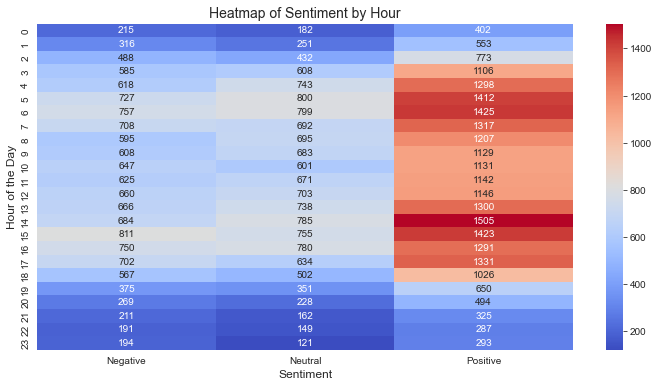

In [233]:
# Heatmap of Sentiment by Hour

# Extract the hour from the 'Date' column
df['Hour'] = pd.to_datetime(df['Date']).dt.hour

# Create a heatmap of sentiment counts by hour
heatmap_data = df.groupby(['Hour', 'Sentiment']).size().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt="d")
plt.title("Heatmap of Sentiment by Hour", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Hour of the Day", fontsize=12)
plt.show()

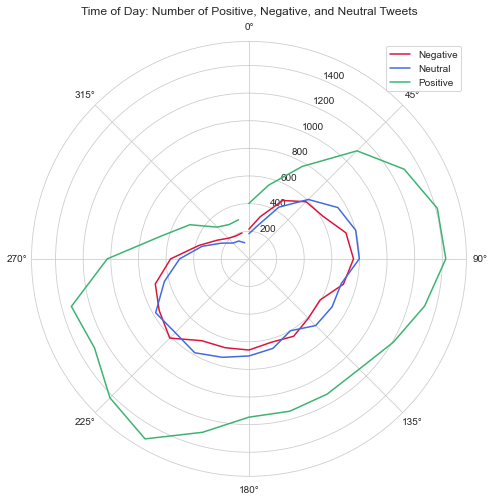

In [234]:
# Polar Line Plot

def format_hour(h: int):
    h = str(h)
    if len(h) == 1: 
        h = '0' + h
    h = h + ":00"
    return h

# Group by 'Sentiment' and 'Hour' and count the number of tweets
sentiment_hourly = df.groupby(['Sentiment', 'Hour'])['Tweet'].count()
sentiment_hourly = pd.DataFrame(sentiment_hourly).reset_index()
sentiment_hourly.columns = ['Sentiment', 'Hour of Day', 'Number of Tweets']

# Format the 'Hour of Day' for display purposes
sentiment_hourly['Hour of Day'] = sentiment_hourly['Hour of Day'].apply(format_hour)

# Prepare data for the polar plot
hours = np.array([int(h.split(":")[0]) for h in sentiment_hourly['Hour of Day']])
radii = sentiment_hourly['Number of Tweets'].values
sentiments = sentiment_hourly['Sentiment'].unique()

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Define colors for each sentiment
colors = {'Positive': 'mediumseagreen', 'Negative': 'crimson', 'Neutral': 'royalblue'}

# Convert hours to radians
theta = np.deg2rad((hours / 24) * 360)

# Plot each sentiment
for sentiment in sentiments:
    mask = sentiment_hourly['Sentiment'] == sentiment
    ax.plot(theta[mask], radii[mask], label=sentiment, color=colors[sentiment])

# Customize the plot
ax.set_theta_zero_location("N")  # Set 0 degrees to the top
ax.set_theta_direction(-1)  # Set the direction clockwise
ax.set_title("Time of Day: Number of Positive, Negative, and Neutral Tweets", va='bottom')
ax.legend(loc='upper right')

# Show the plot
plt.show()

### Statistical Models

In [259]:
df1 = df
df1.head()

,Unnamed: 0,Date,User,Tweet,Cleaned_Tweet,Polarity,Sentiment,Hour
0,0,2023-03-29 15:42:36+00:00,AnandPatni8,@vinodkapri @RahulGandhi Respected Indian Citi...,respected indian citizens namaskaar I original...,-0.062500,0,15
1,1,2023-03-29 15:42:05+00:00,dhinamum,"*Respected Indian Citizens,* Namaskaar I Am Th...",respected indian citizens namaskaar I original...,-0.062500,0,15
2,2,2023-03-29 15:34:29+00:00,PrincetonCGI,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,1 meet filmmaker prakash jha new jersey talkin...,0.173232,2,15
3,3,2023-03-29 15:31:43+00:00,RishiJoeSanu,@MrinalWahal Why would politicians stop using ...,would politicians stop using religion politics...,0.000000,1,15
4,4,2023-03-29 15:26:48+00:00,itweetsensee,@annamalai_k @narendramodi A state level presi...,state level president knows policy pm union mi...,0.214286,2,15


In [260]:
# Train/Test Split

# Feature extraction: Use TF-IDF to transform the Cleaned_Tweet column
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = tfidf_vectorizer.fit_transform(df1['Cleaned_Tweet'])

# Target variable
y = df1['Sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) # Adjust the test size as needed

In [261]:
# Decision Tree Model

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      1992
           1       0.67      0.76      0.71      1930
           2       0.78      0.77      0.77      3578

    accuracy                           0.72      7500
   macro avg       0.70      0.71      0.70      7500
weighted avg       0.72      0.72      0.72      7500



In [262]:
# Random Forest Model

# Train a RF Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.60      0.70      1992
           1       0.73      0.83      0.78      1930
           2       0.79      0.86      0.82      3578

    accuracy                           0.78      7500
   macro avg       0.79      0.76      0.77      7500
weighted avg       0.79      0.78      0.78      7500



In [263]:
# Logistic Regression Model

lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.69      0.75      1992
           1       0.80      0.86      0.83      1930
           2       0.84      0.88      0.86      3578

    accuracy                           0.82      7500
   macro avg       0.82      0.81      0.81      7500
weighted avg       0.83      0.82      0.82      7500



In [264]:
# SVC model

svc_clf = SVC(kernel='linear', random_state=42)
svc_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = svc_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"SVC Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

SVC Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.77      1992
           1       0.81      0.91      0.86      1930
           2       0.87      0.87      0.87      3578

    accuracy                           0.84      7500
   macro avg       0.84      0.83      0.83      7500
weighted avg       0.84      0.84      0.84      7500



In [268]:
# Gradient Boosting Classifier

gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = gb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting Classifier Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Gradient Boosting Classifier Accuracy: 0.68

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.41      0.56      1992
           1       0.69      0.58      0.63      1930
           2       0.64      0.89      0.75      3578

    accuracy                           0.68      7500
   macro avg       0.73      0.63      0.64      7500
weighted avg       0.71      0.68      0.67      7500



In [273]:
# CNN Model

# Label encoding
le = LabelEncoder()
df1['Sentiment'] = le.fit_transform(df1['Sentiment'])

# Splitting the dataset
X = df1['Cleaned_Tweet']
y = df1['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization and Padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Building the CNN Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 output classes: Positive, Negative, Neutral

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train, epochs=10, batch_size=16, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"CNN Model Accuracy: {accuracy:.2f}")

# Predicting on the test set
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = ['Negative', 'Neutral', 'Positive']  # Replace these with the correct labels for your problem
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.6439 - loss: 0.7985 - val_accuracy: 0.8545 - val_loss: 0.4404
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.8729 - loss: 0.3963 - val_accuracy: 0.8562 - val_loss: 0.4438
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9075 - loss: 0.2851 - val_accuracy: 0.8313 - val_loss: 0.5148
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9439 - loss: 0.1717 - val_accuracy: 0.8253 - val_loss: 0.6326
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9677 - loss: 0.1006 - val_accuracy: 0.8123 - val_loss: 0.8062
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9786 - loss: 0.0700 - val_accuracy: 0.8205 - val_loss: 1.1001
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.9865 - loss: 0.0445 - val_accuracy: 0.8180 - val_loss: 1.3358
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9871 -

### TOPSIS Score

In [274]:
df1['Sentiment_score'] = df1['Polarity']

# Step 1: Normalize the decision matrix
criteria_df = df1[['Hour', 'Sentiment_score']].copy()

# Normalization
normalized_df = criteria_df.copy()
normalized_df['Hour'] = 1 - (normalized_df['Hour'] / np.max(normalized_df['Hour']))  # Inverse normalization (lower is better)
normalized_df['Sentiment_score'] = normalized_df['Sentiment_score'] / np.sqrt((normalized_df['Sentiment_score']**2).sum())

# Step 2: Define weights for each criterion (adjust as needed)
weights = np.array([0.4, 0.6])  # Weights for Hour and Sentiment_score

# Step 3: Calculate the weighted normalized decision matrix
weighted_df = normalized_df * weights

# Step 4: Identify the ideal and negative-ideal solutions
ideal_solution = weighted_df.max()  # Best case
negative_ideal_solution = weighted_df.min()  # Worst case

# Step 5: Calculate the distance to the ideal and negative-ideal solutions
distance_to_ideal = np.sqrt(((weighted_df - ideal_solution) ** 2).sum(axis=1))
distance_to_negative_ideal = np.sqrt(((weighted_df - negative_ideal_solution) ** 2).sum(axis=1))

# Step 6: Calculate the TOPSIS score
topsis_score = distance_to_negative_ideal / (distance_to_ideal + distance_to_negative_ideal)

# Rank the options
criteria_df['TOPSIS Score'] = topsis_score
criteria_df['Rank'] = criteria_df['TOPSIS Score'].rank(ascending=False)

# Display the ranked options
print(criteria_df[['Hour', 'Sentiment_score', 'TOPSIS Score', 'Rank']])

       Hour  Sentiment_score  TOPSIS Score     Rank
0        15        -0.062500      0.348114  37468.5
1        15        -0.062500      0.348114  37468.5
2        15         0.173232      0.348437  35991.0
3        15         0.000000      0.348196  36928.0
4        15         0.214286      0.348497  35851.5
...     ...              ...           ...      ...
49996    11        -0.500000      0.521126  26875.0
49997    10         0.400000      0.565504  22386.0
49998    10         0.111111      0.565196  22975.5
49999    10         0.127778      0.565214  22937.0
50000    10        -0.187879      0.564852  24220.0

[50000 rows x 4 columns]


In [ ]:
# The TOPSIS ranking results provide an insightful perspective on how posting times and sentiment scores contribute to the effectiveness of tweets. In this analysis, the Hour and Sentiment_score
# are the key criteria, with lower Hour values being more desirable and higher Sentiment_score indicating more positive sentiment. Observing the table, tweets with similar posting times (e.g., Hour 15)
# have varying sentiment scores, resulting in different TOPSIS scores and ranks. For instance, a sentiment score of 0.214286 at Hour 15 results in a higher TOPSIS score (0.348497), indicating better 
# desirability compared to negative sentiment scores (-0.062500) at the same hour (0.348114). Tweets posted at earlier hours, such as Hour 10 or 11, generally achieved higher TOPSIS scores, which 
# implies that posting at optimal times, combined with positive sentiment, has a significant impact on engagement potential. This analysis complements our sentiment analysis by quantifying the 
# influence of sentiment polarity and timing on the overall effectiveness of the tweets, highlighting the importance of aligning both positive sentiment and strategic posting hours.